In [ ]:
from google.colab import drive

rive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, plot_model

from keras.models import Sequential
from keras.layers import Input, LSTM, Embedding, Dropout, Activation, Reshape, Dense, GRU, Add, Flatten, concatenate

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Embedding, Dropout, Activation, Reshape, Dense, GRU, Add, Flatten, concatenate


In [ ]:
train_bodies = pd.read_csv('/content/train_bodies.csv')
# train_bodies.head()
train_stance = pd.read_csv('/content/train_stances.csv')

In [ ]:
print(len(train_bodies))
print(len(train_stance))

1683
49972


In [ ]:
duplicate_bodies_count = train_bodies["Body ID"].duplicated().sum()
duplicate_stances_count = train_stance["Body ID"].duplicated().sum()

print("Duplicate values in train_bodies:", duplicate_bodies_count)
print("Duplicate values in train_stances:", duplicate_stances_count)

Duplicate values in train_bodies: 0
Duplicate values in train_stances: 48289


In [ ]:
null_bodies_count = train_bodies.isnull().sum()
null_stances_count = train_stance.isnull().sum()

print("Null values in train_bodies:")
print(null_bodies_count)

print("\nNull values in train_stances:")
print(null_stances_count)

Null values in train_bodies:
Body ID        0
articleBody    0
dtype: int64

Null values in train_stances:
Headline    0
Body ID     0
Stance      0
dtype: int64


In [ ]:
  #code to combine the two csv file{train_bodies.csv,train_stances.csv} into data_combined.csv file
#from tqdm.notebook import tqdm
#count=0
#for i in tqdm(range(train_stance.shape[0])):
    #for j in range(train_bodies.shape[0]):
        #if train_bodies.loc[j,'Body ID']==train_stance.loc[i,'Body ID']:
            #train_stance.loc[i,'articleBody'] = train_bodies.loc[j,'articleBody']

#
#train_stance.to_csv('data_combined.csv',index=False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_combined.csv')

In [ ]:
data.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     49972 non-null  object
 1   Body ID      49972 non-null  int64 
 2   Stance       49972 non-null  object
 3   articleBody  49972 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [ ]:
duplicates_count = data.duplicated().sum()
print("no.of duplicates: ",duplicates_count)
null_values = data.isnull().sum()
print("count of null values:\n ",null_values)

no.of duplicates:  402
count of null values:
  Headline       0
Body ID        0
Stance         0
articleBody    0
dtype: int64


In [ ]:
unique_labels = data['Stance'].unique()
print(unique_labels)

['unrelated' 'agree' 'disagree' 'discuss']


In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['Stance'] = encoder.fit_transform(data['Stance'])

In [ ]:
# Mapping of numerical labels to stance classes
label_mapping = dict(zip(encoder.transform(encoder.classes_), encoder.classes_))

# Print the label assigned to each stance
for label, stance in label_mapping.items():
    print(f"Label {label} -> Stance '{stance}'")

Label 0 -> Stance 'agree'
Label 1 -> Stance 'disagree'
Label 2 -> Stance 'discuss'
Label 3 -> Stance 'unrelated'


In [ ]:
data['Stance'].value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

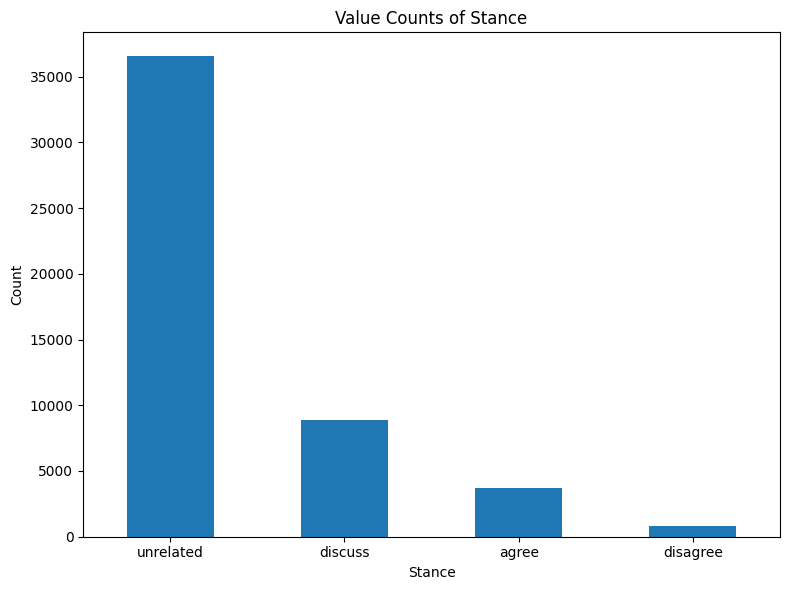

In [ ]:
import matplotlib.pyplot as plt

value_counts = data['Stance'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar')
plt.title('Value Counts of Stance')
plt.xlabel('Stance')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x labels for better visibility if needed
plt.tight_layout()
plt.show()


In [ ]:
data.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [ ]:
data.shape

(49972, 4)

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
import re

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def preprocessing_data(df):

    def clean_data(review):
        review = re.sub('[^a-zA-Z]', ' ', review)
        review = review.lower()
        return review

    def remove_stop_words(review):
        stop_words = set(stopwords.words('english'))
        tokens = review.split()
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def lemmatize(review):
        lemmatizer = WordNetLemmatizer()
        tokens = review.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return ' '.join(tokens)

    # Clean articleBody
    df['articleBody'] = df['articleBody'].apply(clean_data)
    # Remove stopwords from articleBody
    df['articleBody'] = df['articleBody'].apply(remove_stop_words)
    # Lemmatize articleBody
    #df['articleBody'] = df['articleBody'].apply(lemmatize)

    # Clean Headline
    df['Headline'] = df['Headline'].apply(clean_data)
    # Remove stopwords from Headline
    df['Headline'] = df['Headline'].apply(remove_stop_words)
    # Lemmatize Headline
    #df['Headline'] = df['Headline'].apply(lemmatize)

    return df

# Example usage
df = preprocessing_data(data)


In [ ]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/glove.6B.zip', 'r') as z:
  z.extractall()

In [ ]:
import numpy as np

# Load GloVe word embeddings
def load_glove_embeddings(embeddings_file):
    embeddings_index = {}
    with open(embeddings_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings_file = '/content/glove.6B.50d.txt'  # Replace with the path to your GloVe embeddings file
glove_embeddings = load_glove_embeddings(glove_embeddings_file)

# Tokenize text
def tokenize_text(text):
    return text.split()

# Map tokens to GloVe word embeddings
def map_tokens_to_embeddings(tokens, embeddings):
    embedded_tokens = []
    for token in tokens:
        if token in embeddings:
            embedded_tokens.append(embeddings[token])
    return embedded_tokens

# Aggregate word embeddings for each text
def aggregate_word_embeddings(texts, embeddings, aggregation='mean'):
    aggregated_embeddings = []
    for text in texts:
        tokens = tokenize_text(text)
        embedded_tokens = map_tokens_to_embeddings(tokens, embeddings)
        if embedded_tokens:
            if aggregation == 'mean':
                aggregated_embedding = np.mean(embedded_tokens, axis=0)
            elif aggregation == 'sum':
                aggregated_embedding = np.sum(embedded_tokens, axis=0)
            else:
                raise ValueError("Invalid aggregation method. Choose 'mean' or 'sum'.")
            aggregated_embeddings.append(aggregated_embedding)
        else:
            # If no embeddings found for any t
            oken, replace with zeros
            aggregated_embeddings.append(np.zeros_like(embedded_tokens[0]))
    return np.array(aggregated_embeddings)

# Generate embeddings for headlines and article bodies
headline_embeddings = aggregate_word_embeddings(df['Headline'], glove_embeddings)
article_body_embeddings = aggregate_word_embeddings(df['articleBody'], glove_embeddings)

print("Headline Embeddings Shape:", headline_embeddings.shape)
print("Article Body Embeddings Shape:", article_body_embeddings.shape)


Headline Embeddings Shape: (49972, 50)
Article Body Embeddings Shape: (49972, 50)


In [ ]:
labels=df['Stance'].to_numpy()

In [ ]:
from sklearn.model_selection import train_test_split

combined_embeddings = np.concatenate([headline_embeddings, article_body_embeddings], axis=1)

# Split the combined embeddings and the labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, labels, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (39977, 100) (39977,)
Testing set size: (9995, 100) (9995,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Assuming the number of unique labels is 4, as you're using a Dense output layer with 4 units
num_classes = 4  # Adjust based on your dataset

model = Sequential([
    LSTM(units=128, input_shape=(100, 1)),  # Input shape [100, 1] since each example has 100 features and 1 channel
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use 'softmax' if this is a multi-class classification problem
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Since you're using categorical_crossentropy, ensure your labels (y_train and y_test) are one-hot encoded
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))
print(y_train_encoded)

# Reshape X_train and X_test to be 3D as expected by LSTM [samples, timesteps, features]
# In this context, we can treat each feature as a single timestep with 1 feature per timestep.
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Fit the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Epoch 1/10
1000/1000 [==============================] - 204s 201ms/step - loss: 0.8104 - accuracy: 0.7298 - val_loss: 0.7991 - val_accuracy: 0.7316
Epoch 2/10
1000/1000 [==============================] - 167s 167ms/step - loss: 0.7950 - accuracy: 0.7305 - val_loss: 0.7910 - val_accuracy: 0.7316
Epoch 3/10
1000/1000 [==============================] - 164s 164ms/step - loss: 0.7876 - accuracy: 0.7305 - val_loss: 0.7933 - val_accuracy: 0.7316
Epoch 4/10
1000/1000 [==============================] - 165s 165ms/step - loss: 0.7816 - accuracy: 0.7305 - val_loss: 0.7503 - val_accuracy: 0.7316
Epoch 5/10
1000/1000 [==============================] - 193s 193ms/step - loss: 0.7460 - accuracy: 0.7307 - val_loss: 0.7346 - val_accuracy: 0.7345
Epoch 6/10
1000/1000 [==============================] - 197s 197ms/step - loss: 0.7123 - accuracy: 0.7335 - val_loss: 0.7239 - val_accuracy: 0.7325
Epoch 7/10
1000/

In [ ]:
from sklearn.metrics import classification_report

# Predict labels for test set
y_pred = model.predict(X_test_reshaped)
# Convert predicted labels from one-hot encoded to categorical
y_pred_categorical = encoder.inverse_transform(y_pred)

# Convert true labels from one-hot encoded to categorical
y_test_categorical = encoder.inverse_transform(y_test_encoded)

# Generate classification report
report = classification_report(y_test_categorical, y_pred_categorical)
print("Classification Report:")
print(report)


313/313 [==============================] - 22s 70ms/step
Classification Report:
              precision    recall  f1-score   support

       agree       0.46      0.02      0.03       703
    disagree       0.00      0.00      0.00       180
     discuss       0.58      0.55      0.56      1779
   unrelated       0.83      0.93      0.88      7333

    accuracy                           0.78      9995
   macro avg       0.47      0.38      0.37      9995
weighted avg       0.74      0.78      0.75      9995



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 83588 (326.52 KB)
Trainable params: 83588 (326.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


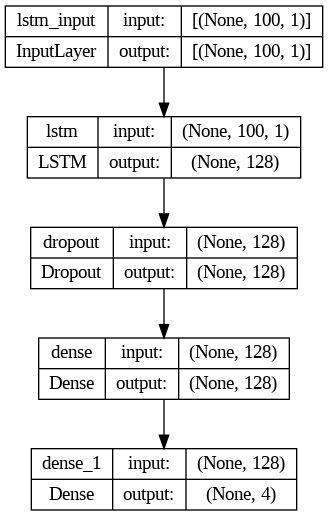

In [ ]:
plot_model(model, to_file='model_one_hot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def predict_stance(headline, article_body, glove_embeddings, model, encoder):
    """
    Predict the stance for a given headline and article body.

    :param headline: The headline text as a string.
    :param article_body: The article body text as a string.
    :param glove_embeddings: The preloaded GloVe embeddings.
    :param model: The trained Keras model for stance detection.
    :param encoder: The OneHotEncoder used to encode the training labels.
    :return: The predicted stance.
    """
    # Tokenize and map to embeddings
    headline_tokens = tokenize_text(headline)
    article_body_tokens = tokenize_text(article_body)
    headline_embeddings = map_tokens_to_embeddings(headline_tokens, glove_embeddings)
    article_body_embeddings = map_tokens_to_embeddings(article_body_tokens, glove_embeddings)

    # Check if embeddings are empty (no tokens found in GloVe)
    if not headline_embeddings or not article_body_embeddings:
        return "Unable to predict stance: No embeddings found."

    # Aggregate embeddings
    headline_embedding = np.mean(headline_embeddings, axis=0).reshape(1, -1)
    article_body_embedding = np.mean(article_body_embeddings, axis=0).reshape(1, -1)

    # Concatenate embeddings
    combined_embedding = np.concatenate([headline_embedding, article_body_embedding], axis=1)

    # Reshape for the model
    input_embedding = combined_embedding.reshape((1, combined_embedding.shape[1], 1))

    # Predict
    prediction = model.predict(input_embedding)

    # Decode the one-hot encoded prediction
    predicted_label = encoder.inverse_transform(prediction)

    return predicted_label[0][0]


# Example usage
headline = "i have a problem with covid it is very dangerous"
article_body = '''many people died because of covid it is very dangerous'''
predicted_stance = predict_stance(headline, article_body, glove_embeddings, model, encoder)
print(f"Predicted Stance: {predicted_stance}")


1/1 [==============================] - 0s 99ms/step
Predicted Stance: unrelated
